$p_{\theta}(s_{t+1}|s_t, a_t) = \{_{pdf(x_{t+1}, \; (x_t+a_t^0), \; \theta_2) \; \times \; pdf(y_{t+1}, \; (y_t+a_t^1), \; \theta_2) \; if \; x_t >= \theta_0}^{pdf(x_{t+1}, \; (x_t+a_t^0), \; \theta_1) \; \times \; pdf(y_{t+1}, \; (y_t+a_t^1), \; \theta_1) \; if \; x_t < \theta_0}$

In [47]:
import numpy as np
import random

theta = [5, (2,4)]

def transiction(s, a, p=2):
    return tuple(np.array(s) + np.array(a) + np.random.normal(0, p, 2))

def pickModel(s, theta):
    psi, sigma = theta
    x,_ = s
    return sigma[int(x >= psi)]

def generate(s, n, theta):   
    for _ in range(n):
        a = random.choice([(1,0), (-1,0), (0,1), (0,-1)])
        yield s, a
        s = transiction(s, a, pickModel(s, theta))

s_0 = (1,1)
O = [(s, a) for (s, a) in generate(s_0, 100, theta)]
O

[((1, 1), (-1, 0)),
 ((-0.7359601574996906, -2.5208159203056715), (0, 1)),
 ((-3.3039818279265973, -0.40309063633137), (-1, 0)),
 ((-5.811928333955676, -0.6338437203943175), (0, 1)),
 ((-5.238955357856269, 4.078502635736696), (1, 0)),
 ((-4.4166338925162565, 2.824843885897928), (0, -1)),
 ((-4.185547627907175, 6.338156450423265), (0, -1)),
 ((-6.697982250276848, 0.28031576529552016), (1, 0)),
 ((-5.7328773228426435, -0.5147347630341982), (1, 0)),
 ((-3.713530199252043, -3.5272770301814353), (0, 1)),
 ((-5.666550543963442, -1.7821559341691646), (1, 0)),
 ((-4.763945899811282, -0.9446609178732956), (1, 0)),
 ((-1.0756236465444782, 0.5953816970783139), (-1, 0)),
 ((-3.4503204212375183, -1.5115546675396936), (0, -1)),
 ((-3.9387676397367475, -7.2388943992650745), (0, 1)),
 ((-4.11980618528567, -10.546921204198341), (-1, 0)),
 ((-2.751433183533209, -9.853874633359363), (1, 0)),
 ((-2.49828754197177, -7.676613933570335), (0, 1)),
 ((-2.8973025947034747, -2.4914811983573095), (-1, 0)),
 ((-1.

$ \theta = \{\psi, \sigma \} $

$\psi$: Parametros para definição do modelo que será utilizado em cada estado<br>
$\sigma$: Parametros para cada Modelo $\{\sigma_1, \sigma_2, ...\}$ <br>

$p_{\theta}(s_{t+1}|s_t, a_t) = \mu(s_{t+1}, s_t, a_t, \sigma_1) \; \times \; \beta(s_t) + \mu(s_{t+1}, s_t, a_t, \sigma_2) \; \times \; \beta(s_t) + ...$



$p_{\theta}(s_{t+1}|s_t, a_t) = \sum_{i=1}^k \mu(s_{t+1}, s_t, a_t, \sigma_i) \beta(s_t)_i \;\;\;\;\; for \;\; k = |\sigma_{\theta}|$  


$\mu: S \times S \times A \times \sigma_{\theta} \mapsto [0,1]; \;\; \mu(s', s, a, \sigma) = pdf(s'_x, (s_x+a_x), \sigma) \; \times \; pdf(s'_y, (s_y+a_y), \sigma)$

##### 2 modelos: Sigmoid

$ \beta: S \mapsto [0,1]; \;\; \beta(s; \psi_{\theta})_i = (i-1) + \frac{1}{1+e^{\psi_{s}}}(-1)^{i-1} $;  <br>
<!-- $ \beta: S \mapsto [0,1]; \;\; \beta(s; \psi_{\theta})_i = 1 - \frac{1}{1+e^{\psi_{s}}} $;  <br> -->
$ for \;\; i = \{1,2\} $

##### N modelos: Softmax

$ \beta: S \mapsto [0,1]; \;\; \beta(s; \psi_{\theta})_i = \frac{e^{\psi_{s,i}}}{\sum_{j=1}^k e^{\psi_{s,j}}} $;   <br>
$ for \;\; k = |\sigma_{\theta}| \;\; ; \;\; i=1,...,k $

$\cal{L}[\xi | \theta] = \sum_{t=0}^{\mathrm{T}-1} log \; p_{\theta}(s_{t+1}|s_t, a_t)$

In [48]:
from scipy.stats import norm

def ll(O, theta):
    psi, sigma = theta

    def mi(x_,y_, x,y, ax, ay, sig):
        return norm.pdf(x_, (x + ax), sig) * norm.pdf(y_, (y + ay), sig) 
    def beta(x,_, i):
        return i + 1/(1+np.e**(10*(x-psi))) * (-1)**i
    def p(s_,s,a):
        return np.sum([mi(*s_,*s,*a, sig)*beta(*s, i) for i,sig in enumerate(sigma)])
    
    return np.sum([np.log(p(st, *O[t-1])) for t,(st,_) in enumerate(O) if t>0])

ll(O, (5, (2, 4)))

-472.068241284452

In [49]:
# best_theta = 0
# best_ll = -np.inf

# for psi in range(10):
#     for p1 in range(10):
#         for p2 in range(10):
#             theta = (psi+1, (p1+1, p2+1))
#             new_ll = ll(O, theta)
#             if new_ll > best_ll:
#                 best_ll = new_ll
#                 best_theta = theta

# print(best_theta, best_ll)

In [50]:
import torch
from torch.autograd import Variable
from torch.distributions import normal

s = Variable(torch.from_numpy(np.array(O)[:-1,0])).type(torch.DoubleTensor)
a = Variable(torch.from_numpy(np.array(O)[:-1,1])).type(torch.IntTensor)
s_ = Variable(torch.from_numpy(np.array(O)[1:,0])).type(torch.DoubleTensor)

# p = torch.nn.parameter.Parameter(torch.Tensor(3).uniform_(1, 10))
p = torch.nn.parameter.Parameter(torch.Tensor([5,2,4]))

mi = torch.cat([(torch.exp(normal.Normal(s[:,0] + a[:,0], i).log_prob(s_[:,0])) * 
                 torch.exp(normal.Normal(s[:,1] + a[:,1], i).log_prob(s_[:,1]))
               ) for i in p[1:]])
beta =  torch.cat((torch.ones(len(O)-1) + torch.sigmoid(-10 * (p[0] - s[:,0])) * (-1)**torch.ones(len(O)-1),
                   torch.zeros(len(O)-1) + torch.sigmoid(-10 * (p[0] - s[:,0])) * (-1)**torch.zeros(len(O)-1)
                ))
p_theta = torch.sum((mi*beta).reshape(2, len(O)-1), 0)
ll = torch.sum(torch.log(p_theta))
ll
# beta.size()

tensor(-472.0682, dtype=torch.float64, grad_fn=<SumBackward0>)

In [51]:
# import torch
# from torch.autograd import Variable
# from torch.distributions import normal

# s = Variable(torch.from_numpy(np.array(O)[:-1,0])).type(torch.DoubleTensor)
# a = Variable(torch.from_numpy(np.array(O)[:-1,1])).type(torch.IntTensor)
# s_ = Variable(torch.from_numpy(np.array(O)[1:,0])).type(torch.DoubleTensor)

# p = torch.nn.parameter.Parameter(torch.Tensor([2,4]))
# # beta
# beta_in = nn.Linear(2, 2)
# beta_out = nn.Linear(2, 2, bias=False)
# beta_activation_function = nn.Softmax(dim=1)
# psi = list(beta_in.parameters()) + list(beta_out.parameters())

# mi = torch.stack([(torch.exp(normal.Normal(s[:,0] + a[:,0], i).log_prob(s_[:,0])) * torch.exp(normal.Normal(s[:,1] + a[:,1], i).log_prob(s_[:,1]))) for i in p],
#                   dim=1
#                 )
# # beta = beta_out(beta_activation_function(beta_in(s.float())))
# beta = beta_activation_function(beta_in(s.float()))
# # p_theta = torch.sum((mi * torch.cat([beta, 1-beta])).reshape(2, len(O)-1), 0)
# p_theta = torch.sum((mi * beta), 1)
# ll = torch.sum(torch.log(p_theta))
# ll

In [52]:
import torch
from torch.autograd import Variable
from torch.distributions import normal
import torch.nn as nn

def estimate(init_p=None):
    s = Variable(torch.from_numpy(np.array(O)[:-1,0])).type(torch.DoubleTensor)
    a = Variable(torch.from_numpy(np.array(O)[:-1,1])).type(torch.IntTensor)
    s_ = Variable(torch.from_numpy(np.array(O)[1:,0])).type(torch.DoubleTensor)

    if init_p is not None:
        sigma = torch.nn.parameter.Parameter(torch.tensor(init_p))
    else:
        sigma = torch.nn.parameter.Parameter(torch.Tensor(2).uniform_(1, 10))

    # beta
    beta_in = nn.Linear(2, 2)
    # beta_in = nn.Linear(2, 1)
    beta_out = nn.Linear(2, 2, bias=False)
    # beta_activation_function = nn.Sigmoid()
    beta_activation_function = nn.Softmax(dim=1)
    psi = list(beta_in.parameters()) + list(beta_out.parameters())

    def loglike():
        mi = torch.stack([(torch.exp(normal.Normal(s[:,0] + a[:,0], sig).log_prob(s_[:,0])) * 
                    torch.exp(normal.Normal(s[:,1] + a[:,1], sig).log_prob(s_[:,1]))
                ) for sig in sigma], dim=1)
        # beta = beta_out(beta_activation_function(beta_in(s.float())))
        beta = beta_activation_function(beta_in(s.float()))
        p_theta = torch.sum((mi * beta), 1) 

        return -torch.sum(torch.log(p_theta))


    # optim = torch.optim.SGD([p], lr=1e-2, momentum=0.9)
    optim = torch.optim.SGD(psi+[sigma], lr=1e-2)

    for i in range(1000):
        ll = loglike()
        if ll.data == torch.inf:
            break
        optim.zero_grad()
        ll.backward()
        optim.step() 

        with torch.no_grad():
            sigma[:] = sigma.clamp(min=1e-1)

    print(i)
    return sigma, lambda x: beta_activation_function(beta_in(x.float()))[0], beta_in


p, beta, layer = estimate()
p

999


Parameter containing:
tensor([2.0684, 4.1327], requires_grad=True)

In [53]:
beta(torch.Tensor([[2,2]]))

tensor([0.9818, 0.0182], grad_fn=<SelectBackward0>)

In [54]:
beta(torch.Tensor([[7,2]])).tolist()

[0.2735939025878906, 0.7264060974121094]

In [55]:

for param in layer.parameters():
  print(param.data)

tensor([[ 0.0081, -0.5960],
        [ 1.0014, -0.5397]])
tensor([ 3.5502, -2.5387])


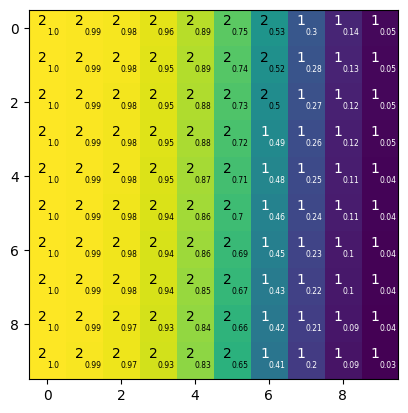

In [56]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca()
ax.invert_yaxis()
    
v = [[beta(torch.Tensor([[x,y]])).tolist()[0] for x in range(10)] for y in range(10)]

ax.imshow(v)

for i, lin in enumerate(v):
    for j, o in enumerate(lin):
        ax.text(j, i, (1,2)[o>.5], ha="right", va="bottom", color=("w", "black")[o>.5])
        ax.text(j, i, round(o, 2), ha="left", va="top", color=("w", "black")[o>.5], size=5.5)
        
# v